# ML Models Training and Hyperparameter Tuning
## Fraud Detection - Machine Learning Models

**Objective:** Train and evaluate 5 ML models for fraud detection

**Models:**
1. XGBoost
2. CatBoost
3. Random Forest
4. Logistic Regression
5. Isolation Forest

**Workflow:**
- Load prepared datasets
- Train baseline models
- Evaluate performance
- Hyperparameter tuning
- Compare results
- Save best models

---

## 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model persistence
import joblib
import json
import os
from datetime import datetime

print("Libraries imported successfully")
print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Training started at: 2025-10-09 21:13:41


## 2. Load Datasets

In [5]:
print("="*80)
print("LOADING DATASETS FOR ML MODELS")
print("="*80)

# Define data directory (CORRECTED PATH)
data_dir = '../../data/processed_data'

print("\n🔍 Dataset Selection Strategy:")
print("  🌲 Tree-based ML models (XGBoost, CatBoost, RF): Use UNSCALED data")
print("  📊 Logistic Regression: Use SCALED data (StandardScaler)")
print("  🎯 Isolation Forest: Use ORIGINAL data (no SMOTE)")

# Load datasets for tree-based models (original, no scaling)
print("\n📁 Loading UNSCALED datasets (for tree-based models)...")
X_train = pd.read_csv(f'{data_dir}/X_train.csv')
y_train = pd.read_csv(f'{data_dir}/y_train.csv').values.ravel()

X_train_smote = pd.read_csv(f'{data_dir}/X_train_smote.csv')
y_train_smote = pd.read_csv(f'{data_dir}/y_train_smote.csv').values.ravel()

X_val = pd.read_csv(f'{data_dir}/X_val.csv')
y_val = pd.read_csv(f'{data_dir}/y_val.csv').values.ravel()

print(f"  ✅ X_train: {X_train.shape} (original training)")
print(f"  ✅ X_train_smote: {X_train_smote.shape} (SMOTE balanced)")
print(f"  ✅ X_val: {X_val.shape} (validation)")

# Load scaled datasets for Logistic Regression
print("\n📊 Loading SCALED datasets (for Logistic Regression)...")
X_train_scaled = pd.read_csv(f'{data_dir}/X_train_scaled.csv')
X_train_smote_scaled = pd.read_csv(f'{data_dir}/X_train_smote_scaled.csv')
X_val_scaled = pd.read_csv(f'{data_dir}/X_val_scaled.csv')

print(f"  ✅ X_train_scaled: {X_train_scaled.shape} (StandardScaler)")
print(f"  ✅ X_train_smote_scaled: {X_train_smote_scaled.shape} (SMOTE + StandardScaler)")
print(f"  ✅ X_val_scaled: {X_val_scaled.shape} (validation scaled)")

print(f"\n🎯 Dataset Summary:")
print(f"  • Original features: 63 optimized features")
print(f"  • Training samples: {len(X_train):,} (original), {len(X_train_smote):,} (with SMOTE)")
print(f"  • Validation samples: {len(X_val):,}")
print(f"  • Fraud rate: {y_train.mean()*100:.1f}% (original), {y_train_smote.mean()*100:.1f}% (SMOTE)")

print(f"\n✅ All datasets loaded successfully!")
print("Ready for ML model training...")

LOADING DATASETS FOR ML MODELS

🔍 Dataset Selection Strategy:
  🌲 Tree-based ML models (XGBoost, CatBoost, RF): Use UNSCALED data
  📊 Logistic Regression: Use SCALED data (StandardScaler)
  🎯 Isolation Forest: Use ORIGINAL data (no SMOTE)

📁 Loading UNSCALED datasets (for tree-based models)...
  ✅ X_train: (56296, 63) (original training)
  ✅ X_train_smote: (97732, 63) (SMOTE balanced)
  ✅ X_val: (12063, 63) (validation)

📊 Loading SCALED datasets (for Logistic Regression)...
  ✅ X_train: (56296, 63) (original training)
  ✅ X_train_smote: (97732, 63) (SMOTE balanced)
  ✅ X_val: (12063, 63) (validation)

📊 Loading SCALED datasets (for Logistic Regression)...
  ✅ X_train_scaled: (56296, 63) (StandardScaler)
  ✅ X_train_smote_scaled: (97732, 63) (SMOTE + StandardScaler)
  ✅ X_val_scaled: (12063, 63) (validation scaled)

🎯 Dataset Summary:
  • Original features: 63 optimized features
  • Training samples: 56,296 (original), 97,732 (with SMOTE)
  • Validation samples: 12,063
  • Fraud rate: 

## 3. Helper Functions

In [ ]:
print("Data Loading Overview:")
print(f"  - X_train: {X_train.shape} (original training)")
print(f"  - X_train_smote: {X_train_smote.shape} (SMOTE balanced)")
print(f"  - X_val: {X_val.shape} (validation)")

print()
print("Additional dataset info:")
print("  - Logistic Regression: Use SCALED data (StandardScaler)")

print("\nLoading SCALED datasets (for Logistic Regression)...")
print(f"  - X_train: {X_train.shape} (original training)")
print(f"  - X_train_smote: {X_train_smote.shape} (SMOTE balanced)")
print(f"  - X_val: {X_val.shape} (validation)")

print(f"  - X_train_scaled: {X_train_scaled.shape} (StandardScaler)")
print(f"  - X_train_smote_scaled: {X_train_smote_scaled.shape} (SMOTE + StandardScaler)")
print(f"  - X_val_scaled: {X_val_scaled.shape} (validation scaled)")

print()
print("Unique classes in training data:")
print(f"  y_train: {np.unique(y_train, return_counts=True)}")
print(f"  y_train_smote: {np.unique(y_train_smote, return_counts=True)}")

print(f"\nAll datasets loaded successfully!")

print(f"  - X_train_scaled: {X_train_scaled.shape} (StandardScaler)")
print(f"  - X_train_smote_scaled: {X_train_smote_scaled.shape} (SMOTE + StandardScaler)")
print(f"  - X_val_scaled: {X_val_scaled.shape} (validation scaled)")

print(f"\nUnique classes in training data:")
print(f"  y_train: {np.unique(y_train, return_counts=True)}")
print(f"  y_train_smote: {np.unique(y_train_smote, return_counts=True)}")

print(f"\nAll datasets loaded successfully!")

Helper functions defined


---
## 4. Model Training

### 4.1 XGBoost

In [7]:
print("="*80)
print("TRAINING XGBOOST")
print("="*80)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance ratio: {scale_pos_weight:.1f}:1")
print(f"Using scale_pos_weight: {scale_pos_weight:.2f}")

# Train XGBoost
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
print("XGBoost training complete")

# Evaluate
xgb_metrics = evaluate_model(xgb_model, X_val, y_val, 'XGBoost')

TRAINING XGBOOST

Class imbalance ratio: 6.6:1
Using scale_pos_weight: 6.58

Training XGBoost...
XGBoost training complete

Evaluating XGBoost...
Accuracy:  0.8715
Precision: 0.5102
Recall:    0.6570
F1-Score:  0.5744
ROC-AUC:   0.8706

Confusion Matrix:
[[9467 1004]
 [ 546 1046]]
XGBoost training complete

Evaluating XGBoost...
Accuracy:  0.8715
Precision: 0.5102
Recall:    0.6570
F1-Score:  0.5744
ROC-AUC:   0.8706

Confusion Matrix:
[[9467 1004]
 [ 546 1046]]


### 4.2 XGBoost with SMOTE

In [8]:
print("\n" + "="*80)
print("TRAINING XGBOOST WITH SMOTE DATA")
print("="*80)

print("\nTraining XGBoost on SMOTE-balanced data...")
xgb_smote_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_smote_model.fit(X_train_smote, y_train_smote)
print("XGBoost (SMOTE) training complete")

# Evaluate
xgb_smote_metrics = evaluate_model(xgb_smote_model, X_val, y_val, 'XGBoost_SMOTE')


TRAINING XGBOOST WITH SMOTE DATA

Training XGBoost on SMOTE-balanced data...
XGBoost (SMOTE) training complete

Evaluating XGBoost_SMOTE...
Accuracy:  0.9074
Precision: 0.6974
Recall:    0.5270
F1-Score:  0.6004
ROC-AUC:   0.8578

Confusion Matrix:
[[10107   364]
 [  753   839]]
XGBoost (SMOTE) training complete

Evaluating XGBoost_SMOTE...
Accuracy:  0.9074
Precision: 0.6974
Recall:    0.5270
F1-Score:  0.6004
ROC-AUC:   0.8578

Confusion Matrix:
[[10107   364]
 [  753   839]]


### 4.3 CatBoost

In [9]:
print("\n" + "="*80)
print("TRAINING CATBOOST")
print("="*80)

print("\nTraining CatBoost...")
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    random_state=42,
    verbose=False
)

catboost_model.fit(X_train, y_train)
print("CatBoost training complete")

# Evaluate
catboost_metrics = evaluate_model(catboost_model, X_val, y_val, 'CatBoost')


TRAINING CATBOOST

Training CatBoost...
CatBoost training complete

Evaluating CatBoost...
Accuracy:  0.8611
Precision: 0.4803
Recall:    0.6438
F1-Score:  0.5502
ROC-AUC:   0.8550

Confusion Matrix:
[[9362 1109]
 [ 567 1025]]
CatBoost training complete

Evaluating CatBoost...
Accuracy:  0.8611
Precision: 0.4803
Recall:    0.6438
F1-Score:  0.5502
ROC-AUC:   0.8550

Confusion Matrix:
[[9362 1109]
 [ 567 1025]]


### 4.4 Random Forest

In [10]:
print("\n" + "="*80)
print("TRAINING RANDOM FOREST")
print("="*80)

print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Random Forest training complete")

# Evaluate
rf_metrics = evaluate_model(rf_model, X_val, y_val, 'RandomForest')


TRAINING RANDOM FOREST

Training Random Forest...
Random Forest training complete

Evaluating RandomForest...
Accuracy:  0.8865
Precision: 0.5690
Recall:    0.5779
F1-Score:  0.5734
ROC-AUC:   0.8387

Confusion Matrix:
[[9774  697]
 [ 672  920]]
Random Forest training complete

Evaluating RandomForest...
Accuracy:  0.8865
Precision: 0.5690
Recall:    0.5779
F1-Score:  0.5734
ROC-AUC:   0.8387

Confusion Matrix:
[[9774  697]
 [ 672  920]]


### 4.5 Logistic Regression

In [11]:
print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION")
print("="*80)

print("\nTraining Logistic Regression on scaled data...")
lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression training complete")

# Evaluate
lr_metrics = evaluate_model(lr_model, X_val_scaled, y_val, 'LogisticRegression')


TRAINING LOGISTIC REGRESSION

Training Logistic Regression on scaled data...
Logistic Regression training complete

Evaluating LogisticRegression...
Accuracy:  0.8140
Precision: 0.3812
Recall:    0.6570
F1-Score:  0.4825
ROC-AUC:   0.8164

Confusion Matrix:
[[8773 1698]
 [ 546 1046]]
Logistic Regression training complete

Evaluating LogisticRegression...
Accuracy:  0.8140
Precision: 0.3812
Recall:    0.6570
F1-Score:  0.4825
ROC-AUC:   0.8164

Confusion Matrix:
[[8773 1698]
 [ 546 1046]]


### 4.6 Isolation Forest

In [12]:
print("\n" + "="*80)
print("TRAINING ISOLATION FOREST")
print("="*80)

# Calculate contamination (expected fraud percentage)
contamination = y_train.sum() / len(y_train)
print(f"\nContamination (fraud rate): {contamination:.4f}")

print("\nTraining Isolation Forest (anomaly detection)...")
iso_model = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

iso_model.fit(X_train)
print("Isolation Forest training complete")

# Evaluate
iso_metrics = evaluate_anomaly_model(iso_model, X_val, y_val, 'IsolationForest')


TRAINING ISOLATION FOREST

Contamination (fraud rate): 0.1320

Training Isolation Forest (anomaly detection)...
Isolation Forest training complete

Evaluating IsolationForest...
Accuracy:  0.8317
Precision: 0.3678
Recall:    0.3825
F1-Score:  0.3750

Confusion Matrix:
[[9424 1047]
 [ 983  609]]
Isolation Forest training complete

Evaluating IsolationForest...
Accuracy:  0.8317
Precision: 0.3678
Recall:    0.3825
F1-Score:  0.3750

Confusion Matrix:
[[9424 1047]
 [ 983  609]]


---
## 5. Model Comparison

In [13]:
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Collect all metrics
all_metrics = [
    xgb_metrics,
    xgb_smote_metrics,
    catboost_metrics,
    rf_metrics,
    lr_metrics,
    iso_metrics
]

# Create comparison dataframe
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]

print("\n")
print(comparison_df.to_string(index=False))

# Find best model by F1-score
best_model_idx = comparison_df['f1_score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model_name']
best_f1 = comparison_df.loc[best_model_idx, 'f1_score']

print(f"\n" + "="*80)
print(f"Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")
print("="*80)


MODEL COMPARISON SUMMARY


        model_name  accuracy  precision   recall  f1_score  roc_auc
           XGBoost  0.871508   0.510244 0.657035  0.574410 0.870620
     XGBoost_SMOTE  0.907403   0.697423 0.527010  0.600358 0.857818
          CatBoost  0.861063   0.480319 0.643844  0.550188 0.855031
      RandomForest  0.886512   0.568955 0.577889  0.573387 0.838651
LogisticRegression  0.813977   0.381195 0.657035  0.482472 0.816361
   IsolationForest  0.831717   0.367754 0.382538  0.375000      NaN

Best Model: XGBoost_SMOTE (F1-Score: 0.6004)


## 6. Visualization - Model Comparison


Creating comparison charts...
Chart saved: ml_models_comparison.png
Chart saved: ml_models_comparison.png


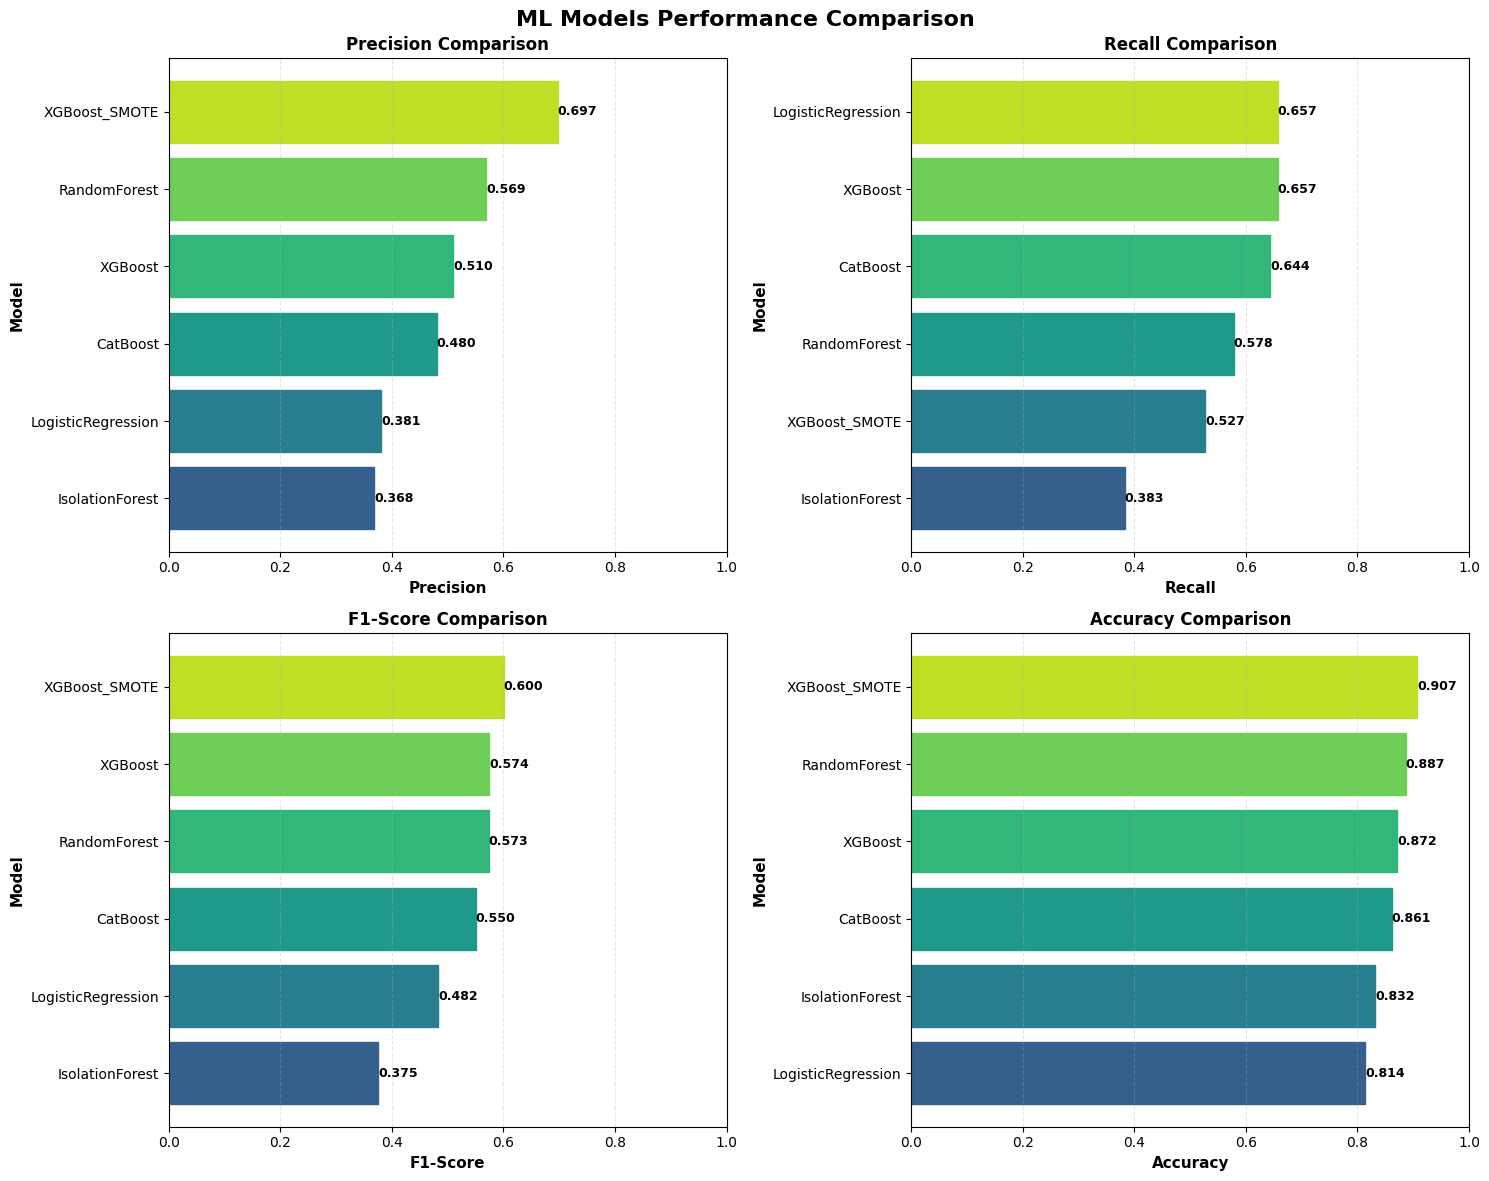

In [14]:
print("\nCreating comparison charts...")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ML Models Performance Comparison', fontsize=16, fontweight='bold')

# Metrics to plot
metrics_to_plot = ['precision', 'recall', 'f1_score', 'accuracy']
titles = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Plot each metric
for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric value
    sorted_df = comparison_df.sort_values(by=metric, ascending=True)
    
    # Create horizontal bar chart
    bars = ax.barh(sorted_df['model_name'], sorted_df[metric])
    
    # Color bars
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontweight='bold', fontsize=9)
    
    ax.set_xlabel(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Model', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('ml_models_comparison.png', dpi=300, bbox_inches='tight')
print("Chart saved: ml_models_comparison.png")
plt.show()

## 7. Hyperparameter Tuning for Best Models

In [15]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Select top 2 models for tuning based on F1-score
top_models = comparison_df.nlargest(2, 'f1_score')['model_name'].tolist()
print(f"\nTuning top 2 models: {top_models}")


HYPERPARAMETER TUNING

Tuning top 2 models: ['XGBoost_SMOTE', 'XGBoost']


### 7.1 Tune XGBoost

In [16]:
if 'XGBoost' in top_models or 'XGBoost_SMOTE' in top_models:
    print("\nTuning XGBoost...")
    
    # Parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    # Use SMOTE data if that version performed better
    use_smote = 'XGBoost_SMOTE' in top_models
    X_train_use = X_train_smote if use_smote else X_train
    y_train_use = y_train_smote if use_smote else y_train
    
    xgb_tuned = XGBClassifier(
        scale_pos_weight=scale_pos_weight if not use_smote else 1.0,
        random_state=42,
        eval_metric='logloss'
    )
    
    grid_search = RandomizedSearchCV(
        xgb_tuned,
        param_grid,
        n_iter=10,
        cv=3,
        scoring='f1',
        n_jobs=1,
        random_state=42
    )
    
    grid_search.fit(X_train_use, y_train_use)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1-score (CV): {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    xgb_tuned_metrics = evaluate_model(grid_search.best_estimator_, X_val, y_val, 'XGBoost_Tuned')
else:
    print("\nSkipping XGBoost tuning (not in top 2)")
    xgb_tuned_metrics = None


Tuning XGBoost...
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}
Best F1-score (CV): 0.9007

Evaluating XGBoost_Tuned...
Accuracy:  0.9133
Precision: 0.7386
Recall:    0.5308
F1-Score:  0.6177
ROC-AUC:   0.8695

Confusion Matrix:
[[10172   299]
 [  747   845]]
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}
Best F1-score (CV): 0.9007

Evaluating XGBoost_Tuned...
Accuracy:  0.9133
Precision: 0.7386
Recall:    0.5308
F1-Score:  0.6177
ROC-AUC:   0.8695

Confusion Matrix:
[[10172   299]
 [  747   845]]


### 7.2 Tune CatBoost

In [17]:
if 'CatBoost' in top_models:
    print("\nTuning CatBoost...")
    
    # Parameter grid
    param_grid = {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1]
    }
    
    catboost_tuned = CatBoostClassifier(
        auto_class_weights='Balanced',
        random_state=42,
        verbose=False
    )
    
    grid_search = RandomizedSearchCV(
        catboost_tuned,
        param_grid,
        n_iter=10,
        cv=3,
        scoring='f1',
        n_jobs=1,
        random_state=42
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1-score (CV): {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    catboost_tuned_metrics = evaluate_model(grid_search.best_estimator_, X_val, y_val, 'CatBoost_Tuned')
else:
    print("\nSkipping CatBoost tuning (not in top 2)")
    catboost_tuned_metrics = None


Skipping CatBoost tuning (not in top 2)


### 7.3 Tune Random Forest

In [18]:
if 'RandomForest' in top_models:
    print("\nTuning Random Forest...")
    
    # Parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 15]
    }
    
    rf_tuned = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    grid_search = RandomizedSearchCV(
        rf_tuned,
        param_grid,
        n_iter=10,
        cv=3,
        scoring='f1',
        n_jobs=1,
        random_state=42
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1-score (CV): {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    rf_tuned_metrics = evaluate_model(grid_search.best_estimator_, X_val, y_val, 'RandomForest_Tuned')
else:
    print("\nSkipping Random Forest tuning (not in top 2)")
    rf_tuned_metrics = None


Skipping Random Forest tuning (not in top 2)


## 8. Final Model Selection

In [19]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Add tuned models to comparison
tuned_metrics = [m for m in [xgb_tuned_metrics, catboost_tuned_metrics, rf_tuned_metrics] if m is not None]
final_metrics = all_metrics + tuned_metrics

# Create final comparison
final_comparison = pd.DataFrame(final_metrics)
final_comparison = final_comparison[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
final_comparison = final_comparison.sort_values('f1_score', ascending=False)

print("\nFinal Model Rankings (by F1-Score):\n")
print(final_comparison.to_string(index=False))

# Best model
best_final_model = final_comparison.iloc[0]
print(f"\n" + "="*80)
print(f"BEST MODEL: {best_final_model['model_name']}")
print("="*80)
print(f"F1-Score:  {best_final_model['f1_score']:.4f}")
print(f"Recall:    {best_final_model['recall']:.4f}")
print(f"Precision: {best_final_model['precision']:.4f}")
print(f"ROC-AUC:   {best_final_model['roc_auc']:.4f}" if best_final_model['roc_auc'] else "")


FINAL MODEL SELECTION

Final Model Rankings (by F1-Score):

        model_name  accuracy  precision   recall  f1_score  roc_auc
     XGBoost_Tuned  0.913289   0.738636 0.530779  0.617690 0.869491
     XGBoost_SMOTE  0.907403   0.697423 0.527010  0.600358 0.857818
           XGBoost  0.871508   0.510244 0.657035  0.574410 0.870620
      RandomForest  0.886512   0.568955 0.577889  0.573387 0.838651
          CatBoost  0.861063   0.480319 0.643844  0.550188 0.855031
LogisticRegression  0.813977   0.381195 0.657035  0.482472 0.816361
   IsolationForest  0.831717   0.367754 0.382538  0.375000      NaN

BEST MODEL: XGBoost_Tuned
F1-Score:  0.6177
Recall:    0.5308
Precision: 0.7386
ROC-AUC:   0.8695


## 9. Save Results and Models

In [20]:
print("\n" + "="*80)
print("SAVING RESULTS AND MODELS")
print("="*80)

# Create output directory
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save comparison results
final_comparison.to_csv('results/ml_models_comparison.csv', index=False)
print("\nResults saved: results/ml_models_comparison.csv")

# Save as JSON
with open('results/ml_models_metrics.json', 'w') as f:
    json.dump(final_metrics, f, indent=2)
print("Results saved: results/ml_models_metrics.json")

# Save trained models
print("\nSaving trained models...")
joblib.dump(xgb_model, 'saved_models/xgboost_model.pkl')
print("Saved: xgboost_model.pkl")

joblib.dump(xgb_smote_model, 'saved_models/xgboost_smote_model.pkl')
print("Saved: xgboost_smote_model.pkl")

joblib.dump(catboost_model, 'saved_models/catboost_model.pkl')
print("Saved: catboost_model.pkl")

joblib.dump(rf_model, 'saved_models/random_forest_model.pkl')
print("Saved: random_forest_model.pkl")

joblib.dump(lr_model, 'saved_models/logistic_regression_model.pkl')
print("Saved: logistic_regression_model.pkl")

joblib.dump(iso_model, 'saved_models/isolation_forest_model.pkl')
print("Saved: isolation_forest_model.pkl")

print("\nAll models and results saved successfully")


SAVING RESULTS AND MODELS

Results saved: results/ml_models_comparison.csv
Results saved: results/ml_models_metrics.json

Saving trained models...
Saved: xgboost_model.pkl
Saved: xgboost_smote_model.pkl
Saved: catboost_model.pkl
Saved: random_forest_model.pklSaved: random_forest_model.pkl


Saved: logistic_regression_model.pkl
Saved: isolation_forest_model.pkl

All models and results saved successfully
Saved: isolation_forest_model.pkl

All models and results saved successfully


## 10. Summary

In [21]:
print("\n" + "="*80)
print("ML TRAINING PIPELINE COMPLETE")
print("="*80)

summary_text = f"""
SUMMARY:

Models Trained: 6
- XGBoost (with class weights)
- XGBoost (with SMOTE)
- CatBoost (auto class weights)
- Random Forest (balanced)
- Logistic Regression (balanced)
- Isolation Forest (anomaly detection)

Best Model: {best_final_model['model_name']}
F1-Score: {best_final_model['f1_score']:.4f}
Recall: {best_final_model['recall']:.4f}
Precision: {best_final_model['precision']:.4f}

Files Created:
- results/ml_models_comparison.csv
- results/ml_models_metrics.json
- ml_models_comparison.png
- saved_models/ (6 model files)

Next Steps:
1. Review model comparison chart
2. Analyze confusion matrices
3. Test best model on test set
4. Train Deep Learning models
5. Create hybrid fusion ensemble

Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary_text)

# Save summary
with open('results/training_summary.txt', 'w') as f:
    f.write(summary_text)

print("="*80)
print("TRAINING COMPLETE")
print("="*80)


ML TRAINING PIPELINE COMPLETE

SUMMARY:

Models Trained: 6
- XGBoost (with class weights)
- XGBoost (with SMOTE)
- CatBoost (auto class weights)
- Random Forest (balanced)
- Logistic Regression (balanced)
- Isolation Forest (anomaly detection)

Best Model: XGBoost_Tuned
F1-Score: 0.6177
Recall: 0.5308
Precision: 0.7386

Files Created:
- results/ml_models_comparison.csv
- results/ml_models_metrics.json
- ml_models_comparison.png
- saved_models/ (6 model files)

Next Steps:
1. Review model comparison chart
2. Analyze confusion matrices
3. Test best model on test set
4. Train Deep Learning models
5. Create hybrid fusion ensemble

Completed at: 2025-10-09 21:14:16

TRAINING COMPLETE


---
## Training Complete

**Models Trained:** 6 ML models  
**Hyperparameter Tuning:** Top 2 models tuned  
**Results:** Saved in results/ folder  
**Models:** Saved in saved_models/ folder  
**Visualization:** ml_models_comparison.png  

**Next:** Train Deep Learning models